## Excluding the Delay Drift Rate Parameter
To evaluate how effectively a model accounts for the responses in our datasets, we applied a likelihood-based model comparison technique introduced by @kragel2015neural that assesses model variants based on how accurately they can predict the specific sequence in which items are recalled. According to this method, repeated items and intrusions (responses naming items not presented in the list) are included from participants' recall sequences. Given an arbitrary parameter configuration and a sequences of recalls to predict, a model simulates encoding of each item presented in the corresponding study list in its respective order. Then, beginning with the first item the participant recalled in the trial, the probability assigned by the model to the recall event is recorded. Next, the model simulates retrieval of that item, and given its updated state is used to similarly predict the next event in the recall sequence - either retrieval of another item, or termination of recall - and so on until retrieval terminates. The probability that the model assigns to each event in the recall sequence conditional on previous trial events are thus all recorded. These recorded probabilities are then log-transformed and summed to obtain the log-likelihood of the entire sequence. Across an entire dataset containing multiple trials, sequence log-likelihoods can be summed to obtain a log-likelihood of the entire dataset given the model and its parameters. Higher log-likelihoods assigned to datasets by a model correspond to better effectiveness accounting for those datasets.

To find the parameter configuration for each model that maximizes its predicted likelihood of observed data, we applied the optimization technique called differential evolution [@storn1997differential] as implemented in the Python library scipy. Differential evolution maintains a population of possible parameter configurations; at each update, the algorithm mutates each population member by stochastically mixing them with other members of the population. If the new configuration of a member is an improvement over its previous configuration, then it becomes part of the updated population. Otherwise, the new parameter configuration is discarded. Through repetition of this process, gradually driving the population toward configurations that maximize the log-likelihood of the observed data assigned by the considered model. This maximal log-likelihood and its corresponding parameter configurations form the basis of comparison between models.

When exploring how effectively the model accounts for qualitative benchmark phenomena in free recall performance such as the temporal contiguity and serial position effects, we optimized parameter configurations and evaluated performance across all subjects in the considered dataset, except where otherwise noted. For direct comparison of the log-likelihoods of recall sequences, however, we search for optimal parameters and perform comparison at the subject level, considering distributions of log-likelihood values calculated between subjects when contrasting model versions.

In [1]:
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_array_from_presentations
from compmemlearn.fitting import lohnas_objective_function
from compmemlearn.models import Classic_CMR
from scipy.optimize import differential_evolution
from numba import njit
import numpy as np
from numba import int32
from compmemlearn.analyses import flex_mixed_spc, flex_mixed_crp, flex_mixed_pfr, fast_csp, alternative_contiguity, rpl
import matplotlib.pyplot as plt

conditions = ['Control', 'Massed', 'Spaced', 'Mixed']

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../../data/repFR.mat')

### Conditionwise Fits
We'll fit CMR to the Lohnas Conditions One-By-One instead of altogether. Tests of generalization between study conditions will be reserved to another section.

In [2]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'mcf_familiarity_scale'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, 100)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cmr_results = []
for condition in [1, 2, 3, 4]:
    selection = list_types == condition
    cost_function = lohnas_objective_function(
        trials[selection], 
        presentations[selection],
        init_cmr,
        {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=True))

differential_evolution step 1: f(x)= 25033.5
differential_evolution step 2: f(x)= 21506.8
differential_evolution step 3: f(x)= 21506.8
differential_evolution step 4: f(x)= 21373.3
differential_evolution step 5: f(x)= 20399.4
differential_evolution step 6: f(x)= 20399.4
differential_evolution step 7: f(x)= 20399.4
differential_evolution step 8: f(x)= 20399.4
differential_evolution step 9: f(x)= 20399.4
differential_evolution step 10: f(x)= 20183.6
differential_evolution step 11: f(x)= 20183.6
differential_evolution step 12: f(x)= 20150.1
differential_evolution step 13: f(x)= 19870.3
differential_evolution step 14: f(x)= 19862.1
differential_evolution step 15: f(x)= 19862.1
differential_evolution step 16: f(x)= 19862.1
differential_evolution step 17: f(x)= 19862.1
differential_evolution step 18: f(x)= 19845.5
differential_evolution step 19: f(x)= 19762.3
differential_evolution step 20: f(x)= 19762.3
differential_evolution step 21: f(x)= 19722.1
differential_evolution step 22: f(x)= 19722

In [3]:
# simulate data corresponding to each cmr_result

from numba.typed import Dict
from numba.core import types
from numpy import matlib

experiment_count = 1000

sim_trials = []
sim_presentations = []
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

for i, cmr_result in enumerate(cmr_results):

    for j in range(len(cmr_result.x)):
        fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
        
    fitted_parameters['sampling_rule'] = 0
    fitted_parameters['mfc_familiarity_scale'] = 0
    fitted_parameters['drift_familiarity_scale'] = 0
    fitted_parameters['delay_drift_rate'] = 0

    sim_trials.append(simulate_array_from_presentations(
        init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count))
    sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

### Serial Position Curve

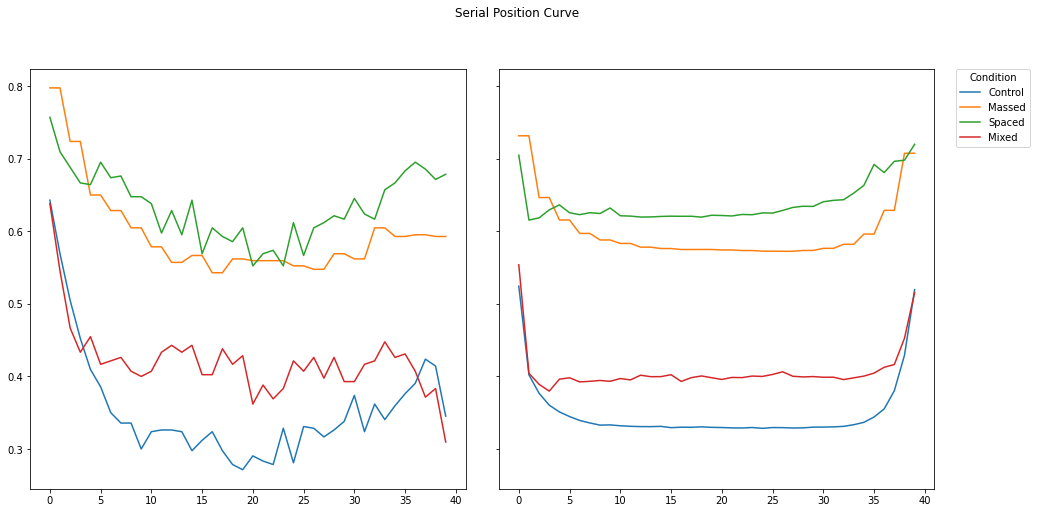

In [4]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):
    
    test_spc= flex_mixed_spc(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_spc)), test_spc, label=conditions[condition])

    sim_spc = flex_mixed_spc(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_spc)), sim_spc, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='Recall Rate') 
fig.suptitle("Serial Position Curve")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Lag-CRP

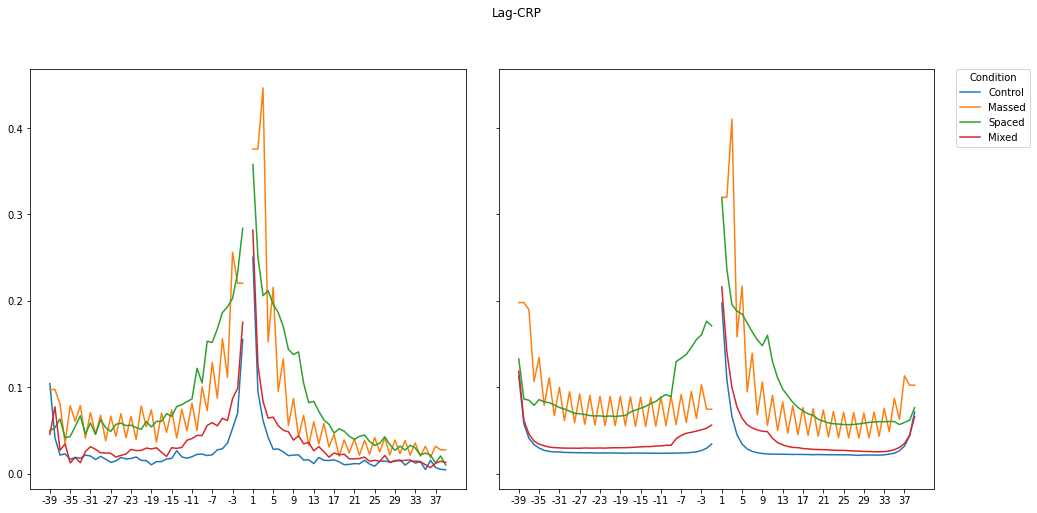

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):

    test_crp= flex_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    axes[0].plot(np.arange(len(test_crp)), test_crp, label=conditions[condition])

    sim_crp = flex_mixed_crp(sim_trials[condition], sim_presentations[condition])
    sim_crp[len(presentations[0])-1] = np.nan
    axes[1].plot(np.arange(len(sim_crp)), sim_crp, label=conditions[condition])

#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability')   
axes[0].set_xticks(np.arange(0, len(test_crp), 4))
axes[0].set_xticklabels(np.arange(0, len(test_crp), 4) - 39)
axes[1].set_xticks(np.arange(0, len(sim_crp), 4))
axes[1].set_xticklabels(np.arange(0, len(sim_crp), 4) - 39)
fig.suptitle('Lag-CRP')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Probability of First Recall

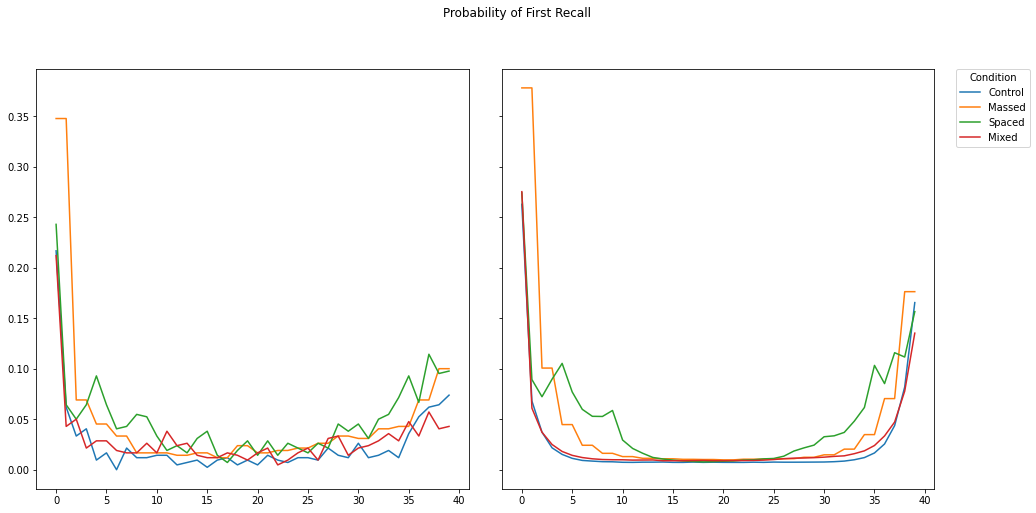

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):

    test_pfr = flex_mixed_pfr(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_pfr)), test_pfr, label=conditions[condition])

    sim_pfr = flex_mixed_pfr(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_pfr)), sim_pfr, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='First Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='First Recall Rate') 
fig.suptitle("Probability of First Recall")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Conditional Stop Probability

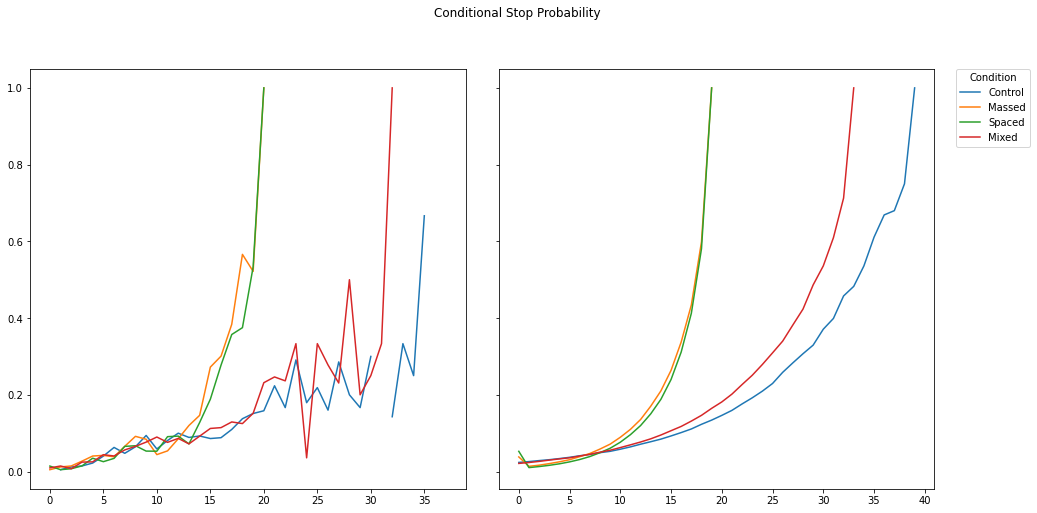

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):
    test_csp = fast_csp(trials[list_types==condition+1], list_length)
    test_csp[test_csp==0] = np.nan
    axes[0].plot(np.arange(list_length+1), test_csp, label=conditions[condition])

    sim_csp = fast_csp(sim_trials[condition], list_length)
    sim_csp[sim_csp==0] = np.nan
    axes[1].plot(np.arange(list_length+1), sim_csp, label=conditions[condition])

#plt.xlabel('Recall Position')
#plt.ylabel('Conditional Stop Probability')
fig.suptitle('Conditional Stop Probability')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Alternative Contiguity

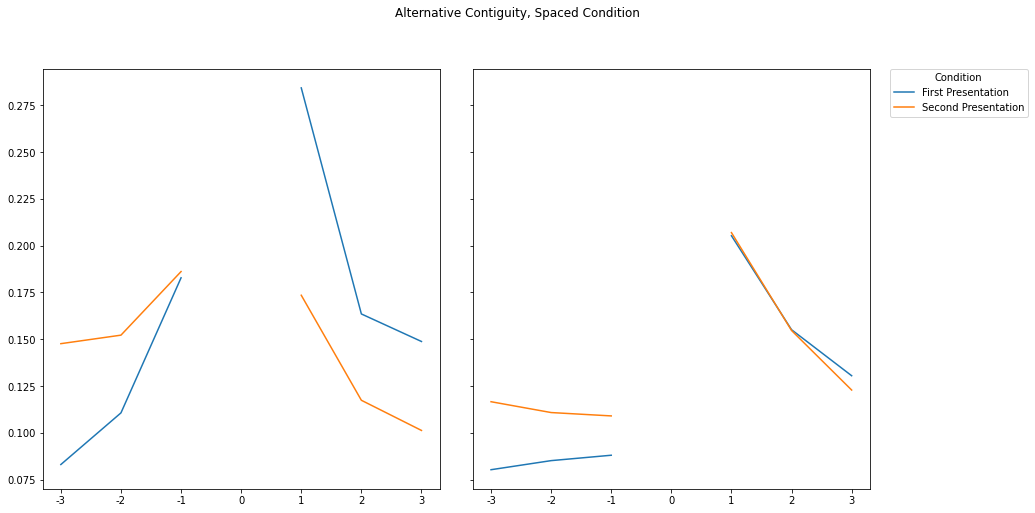

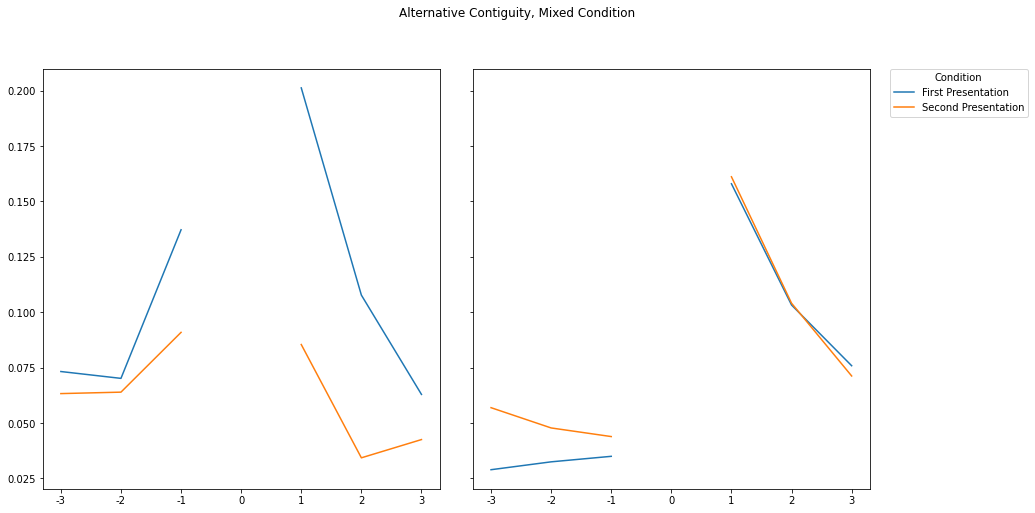

In [9]:
for condition in range(2, 4):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)
    
    test_altcrp= alternative_contiguity(
        trials[list_types==condition+1], presentations[list_types==condition+1], 6, 2)
    test_altcrp[:, list_length-1] = np.nan
    axes[0].plot(np.arange(7), test_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
    axes[0].plot(np.arange(7), test_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
    axes[0].set_xticks(np.arange(7))
    axes[0].set_xticklabels(np.arange(7) -3) 

    sim_altcrp = alternative_contiguity(
        sim_trials[condition], sim_presentations[condition], 6, 2)
    sim_altcrp[:, list_length-1] = np.nan
    axes[1].plot(np.arange(7), sim_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
    axes[1].plot(np.arange(7), sim_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
    axes[1].set_xticks(np.arange(7))
    axes[1].set_xticklabels(np.arange(7) -3)

    axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('Alternative Contiguity, ' + conditions[condition] + ' Condition')
    plt.tight_layout(pad=3)
    #plt.xlabel('Lag')
    #plt.ylabel('Conditional Response Probability')   


### Spacing Effect

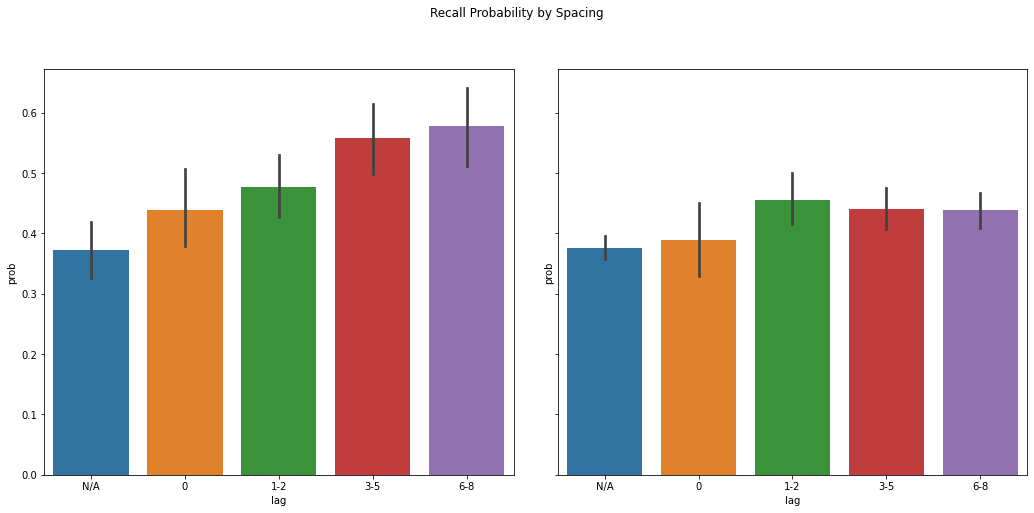

In [10]:
import seaborn as sns

condition = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = rpl(
    presentations[list_types==condition], trials[list_types==condition], 
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[0], data=data, x='lag', y='prob')

sim_data = rpl(
    sim_presentations[3], sim_trials[3],
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[1], data=sim_data, x='lag', y='prob')
    
fig.suptitle("Recall Probability by Spacing")
plt.tight_layout(pad=3)